In [173]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import pprint
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor, Lasso, ElasticNet, Ridge, LassoCV, ElasticNetCV, RidgeCV, LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import statsmodels.formula.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import sklearn.metrics
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score, v_measure_score, adjusted_mutual_info_score
from selenium import webdriver
import os
import requests
from bs4 import BeautifulSoup
import json
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
from timeit import default_timer as timer
# REQUIREMENTS:
# pip install pydotplus
# brew install graphviz

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import kaggle

### NLP
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
import pandas as pd

### Ways to load stopwords
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

In [2]:
ag = pd.read_csv('age_gender_bkts.csv')
cty = pd.read_csv('countries.csv')
sample_submission = pd.read_csv('sample_submission_NDF.csv')
sessions = pd.read_csv('sessions.csv')
df_test = pd.read_csv('test_users.csv')
df_train = pd.read_csv('train_users_2.csv')

In [3]:
sessions.shape, df_train.shape, df_test.shape

((10567737, 6), (213451, 16), (62096, 15))

In [4]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


# Helper Functions

In [6]:
def find_distinct_action_timescores(df_input, sessions, optimizing_class ='NDF'):
    """
        Function that takes in
            df_input as a DataFrame of train data
            sessions as a DataFrame of sessions information
            optimizing_class as a string of the class to look out for
        
        Outputs a dictionary of the absolute time diff between class yes and no and its action 
    """
    df = df_input.copy(deep=True)
    
    df['optimizing_class_boolean'] = [1 if val == optimizing_class else 0 for val in df['country_destination']]
    
    dict_timescore = {}
    timescore_list = []
    start = timer()

    for action in sessions['action'].value_counts().index[:75]:
        print ('>', end='')
        action_sessions = sessions[sessions['action']==action].groupby('user_id').sum()['secs_elapsed']
        df_holding = df.merge(action_sessions.reset_index(), how='left', left_on='id', right_on='user_id')
        
        time_array = df_holding.groupby(['optimizing_class_boolean']).mean()['secs_elapsed'] 
        timescore = time_array[1] - time_array[0]
        
        dict_timescore[abs(timescore)] = [action, timescore]
        timescore_list += [abs(timescore)]
        
    end = timer()
    print (' {} seconds elapsed...'.format(end-start))

    return dict_timescore, timescore_list

##### Create X, y, and test sets for each of the location classes

In [7]:
def create_set(train, test, sessions, timescores_info, timescore_limit=10):
    
    train_set = train.copy(deep=True)
    test_set = test.copy(deep=True)
    
    df_dictionary = {}
    
    
    for location_class in train_set['country_destination'].unique():
        start = timer()
        
        print ('Start {} > '.format(location_class), end='' )
        ### Get the timescore_list and dict_timescore for location class
        timescore_list = timescores_info[location_class][0]
        dict_timescore = timescores_info[location_class][1]
        
        print ('Getting Actions > ', end='' )
        ### Get top 10 timescore actions
        action_list = get_top_actions(timescore_list, dict_timescore, timescore_limit)
        
        print ('Aggregating train/test sets > ', end='' )
        ### Aggregate train and test sets with second elapsed for actions
        agg_train = agg_action_with_data(train_set, sessions, action_list).copy(deep=True)
        agg_test = agg_action_with_data(test_set, sessions, action_list).copy(deep=True)
        
        print ('Justifying Columns > ', end='' )
        ### Justify the columns 
        ### Fill agg_test with columns unique only to agg_train, values = 0 
        for column in agg_train.columns:
            if column not in agg_test.columns:
                agg_test[column] = 0 

        ### Fill agg_train with columns unique only to agg_test, values = 0
        for column in agg_test.columns:
            if column not in agg_train.columns:
                agg_train[column] = 0 
        
        ### Align agg_test columns with agg_train columns 
        agg_test = agg_test[agg_train.columns]
        
        print ('Saving... > ', end='' )
        ### Store information in massive dictionary called df_dictionary
        df_dictionary[location_class] = [agg_train.copy(deep=True), agg_test.copy(deep=True)]
        
        end = timer()
        print ('Completed {}, {} seconds elapsed'.format(location_class, end-start))
        
    return df_dictionary

In [8]:
def get_top_actions(timescore_list, dict_timescore, actions=10):
    """
        Function that takes in;
            timescore_list as a list, ordered timescores
            dict_timescore as a dictionary, with the timescores as keys and the action & non-abs-timescores as values
            action as int, number of actiosn to grab
            
        Returns a list of the top # actions
    """
    
    action_list = []
    
    for timescore in timescore_list[:actions]:
        
        action_list += [dict_timescore[timescore][0]]
        
    return action_list

In [9]:
def agg_action_with_data(data, sessions, action_list):
    """
        Funtion that takes in;
            data as DataFrame, base dataset to becombined
            sessions as DataFrame, sessions log information
            action_list as list, the list of actions to be added
            
        Add the avg time spent for each action in the action_list for each user to the main dataset
            
    """

    data_out = data.copy(deep=True)
    for action in action_list:

        session_action = sessions[sessions['action']==action].groupby('user_id').mean()[['secs_elapsed']]
        data_out = data_out.merge(session_action, how='left', left_index=True, right_index=True)
        data_out.rename(mapper={'secs_elapsed':action + '_secs_elapsed'}, axis=1, inplace=True)

    ### Clean the new columns and deal with nulls by converting them to 0
    for action in action_list:
        data_out[action +'_secs_elapsed'].fillna(value=0, inplace=True)
        data_out[action +'_secs_elapsed'] = data_out[action +'_secs_elapsed'].apply(lambda val: int(np.round(val, 0)))
        
    return data_out

##### Run many models

In [10]:
def run_many_models(massive_df_dictionary, location_classes, on_dataset='test'):
    """
        takes in; 
            massive_df_dictionary as a dictionary of DataFrames
            location_classes as a list of location_classes
            
        Run a RandomForest model through each of it and saves down the predict_proba for each of it.
    """
    if on_dataset == 'test':
        df_out = pd.DataFrame(index=massive_df_dictionary['NDF'][1].index.values)
    elif on_dataset == 'train':
        df_out = pd.DataFrame(index=massive_df_dictionary['NDF'][0].index.values)
    
    for location_class in location_classes:
        start = timer()
        
        print ('Start {} > '.format(location_class), end ='')
        train = massive_df_dictionary[location_class][0]
        test = massive_df_dictionary[location_class][1]
        
        print ('Ready data for modeling > ', end='')
        X_train = train.drop(columns=['country_destination']).copy(deep=True)
        y_train = [1 if val == location_class else 0 for val in train['country_destination']]
        
        if on_dataset == 'test':
            X_test = test.drop(columns=['country_destination']).copy(deep=True)
        elif on_dataset == 'train':
            X_test = X_train
        
        print ('Fitting Model > ', end='')
        rdf = RandomForestClassifier(n_jobs=10, n_estimators=100, random_state=0, class_weight='balanced')
        rdf.fit(X_train, y_train)
        
        print ('Getting Probas > ', end='')
        pred_proba = pd.DataFrame(rdf.predict_proba(X_test), index=X_test.index.values, columns=rdf.classes_)
        pred_proba.rename(mapper={1: location_class + '_Y', 0: location_class + '_N'}, axis = 1, inplace=True)
        
        print ('Saving > ', end='')
        df_out = df_out.merge(pred_proba, how='left', left_index=True, right_index=True)
        
        end = timer()
        print ('Done {}, {} secconds'.format(location_class, np.round(end-start)))
        
    return df_out

#### Find top choices function

In [11]:
def find_top_choices(df, threshold = 0.9, max_picks=5):
    holding_list = []
    
    for row in df.index:
        sum_prob = 0
        prob_dict = {}
        prob_list = []
        
        for col in df.columns:
            prob = df.loc[row, col]
            prob_dict[prob] = col
            prob_list += [prob]
            
        prob_list.sort(reverse=True)
        
        thres_checker = 0
        for proba in prob_list[:max_picks]:
            if proba == 0:
                break
            
            holding_list += [[row, prob_dict[proba]]]
            thres_checker += proba
            if thres_checker > threshold:
                break
                
    output_df = pd.DataFrame(holding_list, columns=['id', 'country'])
    output_df.drop_duplicates(inplace=True)
    output_df.set_index(keys='id', inplace=True)
    
    return output_df

In [174]:
### Submit to kaggle
def submit_to_kaggle(output, filename, message='null'):
    
    if type(output) != pd.core.frame.DataFrame:
        file = pd.DataFrame(output, columns=['country'], index=kaggle_test.index)
    else:
        file = output.copy(deep=True)
    file.to_csv(path_or_buf=filename + '.csv')
    kaggle.api.competition_submit(file_name=filename + '.csv', message=message, competition= 'airbnb-recruiting-new-user-bookings')

In [13]:
### Create encoder to encoder y values to use neural network
import copy
def ANN_encoder(y): 
    
    location_classes = y.unique()
    encoder = {}
    
    for i, location_class in enumerate(location_classes):
        encoder[location_class] = i
    
    output_array = []
    
    for location in y:
        builder = []
        for i in range(len(location_classes)):
            if i == encoder[location]:
                builder += [1]
                
            else:
                builder += [0]
                
        output_array += [copy.deepcopy(builder)]
    
    decoder = {encoder[key] : key for key in encoder.keys()}
        
    return decoder, np.array(output_array)

# Cleaning Data

##### Deal with the age part

In [142]:
df_age = df_train.copy(deep=True)

### using date of account creation as current date, calculate the age for those with inputs as number of years
aegis = []
for date, age in zip(df_age['date_account_created'], df_age['age']):
    if np.isnan(age) == False:
        if age >= 1000:
            aegis += [float(date[:4]) -age]
        else:
            aegis += [age]
    else:
        aegis += [age]
        
### Add the first order treated age back to the training set
df_age['age'] = aegis

### Turn anyone below 10years old into np.nan for easy treatment
df_age['age'] = [np.nan if val <= 10 else val for val in df_age['age']]

### Turn anyone above 100years old into np.nan for easy treatment
df_age['age'] = [np.nan if val > 100 else val for val in df_age['age']]

### Get the age mean of people within sane range of above 10 to 100 in the training set, rest are considered errors to be treated
sane_age_mean = np.round(df_age[(df_age['age'] > 10)  &  (df_age['age'] <= 100)]['age'].mean(), 0)

### Fill the np.nans with the calculated mean age
df_age['age'] = df_age['age'].fillna(sane_age_mean)


# df_age[(df_age['age'] > 100)]
df_age['age']

0         37.0
1         38.0
2         56.0
3         42.0
4         41.0
5         37.0
6         46.0
7         47.0
8         50.0
9         46.0
10        36.0
11        47.0
12        37.0
13        37.0
14        36.0
15        33.0
16        37.0
17        31.0
18        37.0
19        29.0
20        37.0
21        30.0
22        40.0
23        37.0
24        40.0
25        26.0
26        37.0
27        32.0
28        35.0
29        37.0
          ... 
213421    37.0
213422    37.0
213423    20.0
213424    32.0
213425    30.0
213426    37.0
213427    37.0
213428    37.0
213429    37.0
213430    19.0
213431    37.0
213432    31.0
213433    37.0
213434    37.0
213435    37.0
213436    37.0
213437    37.0
213438    37.0
213439    43.0
213440    24.0
213441    34.0
213442    37.0
213443    36.0
213444    37.0
213445    23.0
213446    32.0
213447    37.0
213448    32.0
213449    37.0
213450    37.0
Name: age, Length: 213451, dtype: float64

#### Treating null values & Feature Engineering

In [143]:
df = df_age.copy(deep=True)

### Set ids as index
df.reset_index(inplace=True)
df.set_index(df['id'], inplace=True)

### Drop data_first_booking as it is not available in the test set 
df.drop(columns=['date_first_booking'], inplace=True)

### Fill np.nan of 'first_affiliate_tracked' information with 'untracked'
df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('untracked')


# ### Create new time of the day columns using timestamp_first_active column
# df['tod_first_active'] = [str(time)[4:6] for time in df['timestamp_first_active']]


### Drop columns that are not useful in helping to predict
df.drop(columns=['index','id', 'date_account_created', 'timestamp_first_active'], inplace=True)

df = pd.get_dummies(df, columns=['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser'])
df.shape

(213451, 149)

In [16]:
### Find the time diff for the first 75 actions for each location class
### Gather the top 10 actions for each of the location classes

info_dict = {}
top10_cumulative =set()

for location_class in df_train['country_destination'].unique():
    
    print (location_class, end=' ')
    dict_timescore, timescore_list = find_distinct_action_timescores(df_train, sessions, location_class)
    timescore_list.sort(reverse=True)
    info_dict[location_class] = [timescore_list, dict_timescore]
    
    print ('getting actions from timescores...')
    for timescore in timescore_list[:10]:
        top10_cumulative.update([dict_timescore[timescore][0]])

NDF >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 292.9976268974501 seconds elapsed...
getting actions from timescores...
US >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 245.68772484068404 seconds elapsed...
getting actions from timescores...
other >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 266.2695300960139 seconds elapsed...
getting actions from timescores...
FR >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 216.75958991749098 seconds elapsed...
getting actions from timescores...
CA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 175.39241432691676 seconds elapsed...
getting actions from timescores...
GB >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 163.1885663483206 seconds elapsed...
getting actions from timescores...
ES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 170.3899

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


#### Aggregating & merging train set and session information

In [144]:
df1 = df.copy(deep=True)

### Add in the avg time spend on each action based on those with the highest difference between those who flew and those who didn't
### Add average secs_elapsed information for each action to the main training set
for action in top10_cumulative:
    
    session_action = sessions[sessions['action']==action].groupby('user_id').mean()[['secs_elapsed']]
    df1 = df1.merge(session_action, how='left', left_index=True, right_index=True)
    df1.rename(mapper={'secs_elapsed':action + '_secs_elapsed'}, axis=1, inplace=True)
    
### Clean the new columns and deal with nulls by converting them to 0
for action in top10_cumulative:
    df1[action +'_secs_elapsed'].fillna(value=0, inplace=True)
    df1[action +'_secs_elapsed'] = df1[action +'_secs_elapsed'].apply(lambda val: int(np.round(val, 0)))

# Create a function to do the same treatment for df_test

In [149]:
def treat_test(test, sane_age_mean):
    
    df_age = test.copy(deep=True)

    ### using date of account creation as current date, calculate the age for those with inputs as number of years
    aegis = []
    for date, age in zip(df_age['date_account_created'], df_age['age']):
        if np.isnan(age) == False:
            if age >= 1000:
                aegis += [float(date[:4]) -age]
            else:
                aegis += [age]
        else:
            aegis += [age]

    ### Add the first order treated age back to the training set
    df_age['age'] = aegis

    ### Turn anyone below 10years old into np.nan for easy treatment
    df_age['age'] = [np.nan if val <= 10 else val for val in df_age['age']]

    ### Turn anyone above 100years old into np.nan for easy treatment
    df_age['age'] = [np.nan if val > 100 else val for val in df_age['age']]

    ### Fill the np.nans with the calculated mean age
    df_age['age'] = df_age['age'].fillna(sane_age_mean)

    df = df_age.copy(deep=True)

    ### Set ids as index
    df.reset_index(inplace=True)
    df.set_index(df['id'], inplace=True)

    ### Drop data_first_booking as it is not available in the test set 
    df.drop(columns=['date_first_booking'], inplace=True)

    ### Fill np.nan of 'first_affiliate_tracked' information with 'untracked'
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('untracked')


    # ### Create new time of the day columns using timestamp_first_active column
    # df['tod_first_active'] = [str(time)[4:6] for time in df['timestamp_first_active']]


    ### Drop columns that are not useful in helping to predict
    df.drop(columns=['index','id', 'date_account_created', 'timestamp_first_active'], inplace=True)

    ### Create dummies for categorical features
    df = pd.get_dummies(df, columns=['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser'])

    return df

In [150]:
df_test_cleaned = treat_test(df_test, sane_age_mean)


for action in top10_cumulative:
    
    session_action = sessions[sessions['action']==action].groupby('user_id').mean()[['secs_elapsed']]
    df_test_cleaned = df_test_cleaned.merge(session_action, how='left', left_index=True, right_index=True)
    df_test_cleaned.rename(mapper={'secs_elapsed':action + '_secs_elapsed'}, axis=1, inplace=True)
    
### Clean the new columns and deal with nulls by converting them to 0
for action in top10_cumulative:
    df_test_cleaned[action +'_secs_elapsed'].fillna(value=0, inplace=True)
    df_test_cleaned[action +'_secs_elapsed'] = df_test_cleaned[action +'_secs_elapsed'].apply(lambda val: int(np.round(val, 0)))


for column in df1.columns:
    if column not in df_test_cleaned.columns:
        df_test_cleaned[column] = 0 
        
for column in df_test_cleaned.columns:
    if column not in df1.columns:
        df1[column] = 0 
        
df_test_cleaned = df_test_cleaned[df1.columns]

df_test_cleaned.shape, df1.shape

((62096, 183), (213451, 183))

### Ready data for modeling

In [151]:
### Ready data for modeling
X = df1.drop(columns=['country_destination']).copy(deep=True)
y = df1['country_destination']

### Create X for test set from kaggle
kaggle_test = df_test_cleaned.drop(columns=['country_destination']).copy(deep=True)

### Create a standardized version for the models 
ss = StandardScaler()
Xs = pd.DataFrame(ss.fit_transform(X), index = X.index, columns = X.columns)
kaggle_test_std = pd.DataFrame(ss.fit_transform(kaggle_test), index = kaggle_test.index, columns = kaggle_test.columns)

# y = [1 if val == 'NDF' else 0 for val in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=0)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, y, test_size=.10, random_state=0)

### Encoder ys to be used for neural networks
decoder_yNN, yNN = ANN_encoder(y)
decoder_yNN_train, yNN_train = ANN_encoder(ys_train)
decoder_yNN_test, yNN_test = ANN_encoder(ys_test)

for train, test in zip(y_train.values, ys_train.values):
    if train != test:
        print ('gg')

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.



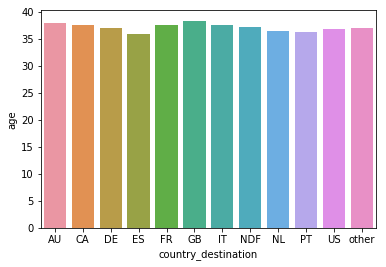

In [22]:
sns.barplot(x='country_destination', y='age',data=df1.groupby('country_destination').mean()['age'].reset_index())

# Modeling

#### RandomForest

In [23]:
### Try baseline random forest
rdf = RandomForestClassifier(n_jobs=10, n_estimators=100, random_state=0, class_weight='balanced')
rdf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=10, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [24]:
rdf.score(X_test, y_test)

0.6872950435678816

In [26]:
submit_to_kaggle(rdf.predict(kaggle_test), 'first_try')

100%|███████████████████████████████████████████████████████████████████| 960k/960k [00:04<00:00, 197kB/s]


In [27]:
### Doesn't seem very good at predicting when doing train test split, though it seems to yield a not too bad first score at kaggle of 0.69
### Try submitting more guesses for each user
rdf_more_guesses = find_top_choices(pd.DataFrame(rdf.predict_proba(kaggle_test), columns=rdf.classes_, index=kaggle_test.index), threshold=1)
submit_to_kaggle(rdf_more_guesses, 'first try with more than one guess')

100%|█████████████████████████████████████████████████████████████████| 3.86M/3.86M [00:05<00:00, 732kB/s]


In [28]:
### With just more than one guess, the score is immediately shot up to 0.85

#### LogisticRegression

In [29]:
### Try baseline logistic Regression
logr = LogisticRegression(verbose=2, n_jobs=10, solver='lbfgs', class_weight='balanced')
logr.fit(Xs_train, ys_train)

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   7 out of  12 | elapsed:  2.0min remaining:  1.4min
[Parallel(n_jobs=10)]: Done  12 out of  12 | elapsed:  2.9min finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=10, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=2, warm_start=False)

In [30]:
logr.score(Xs_test, ys_test)

0.3883163121896374

In [31]:
submit_to_kaggle(logr.predict(kaggle_test_std), 'first_try for logistic regression')

100%|███████████████████████████████████████████████████████████████████| 929k/929k [00:04<00:00, 219kB/s]


In [32]:
### Results form logistic regression seems to be quite terrible on both counts, 0.31 on kggle
### Try with more than 1 guesses for each user
logr_more_guesses = find_top_choices(pd.DataFrame(logr.predict_proba(kaggle_test_std), columns=logr.classes_, index=kaggle_test_std.index), threshold=1)
submit_to_kaggle(logr_more_guesses, filename='FTlogrG', message='first try for logistic_regression with more than one guess')

100%|████████████████████████████████████████████████████████████████| 4.54M/4.54M [00:04<00:00, 1.01MB/s]


In [33]:
### Logistic Regression seems to be inferior in every way with a score of 0.47

#### Artificial Neural Network

In [34]:
classifier = Sequential()
classifier.add(Dense(output_dim = 48, init = 'uniform', activation = 'relu', input_dim = Xs_train.shape[1]))
classifier.add(Dense(output_dim = 24, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 12, init = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics = [keras.metrics.categorical_accuracy])
classifier.fit(Xs_train, yNN_train, nb_epoch = 10, batch_size= 64, verbose=2)

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=182, units=48, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=24, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=12, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/10
 - 13s - loss: 1.1389 - categorical_accuracy: 0.6053
Epoch 2/10
 - 12s - loss: 1.0920 - categorical_accuracy: 0.6158
Epoch 3/10
 - 12s - loss: 1.0760 - categorical_accuracy: 0.6212
Epoch 4/10
 - 12s - loss: 1.0647 - categorical_accuracy: 0.6297
Epoch 5/10
 - 12s - loss: 1.0597 - categorical_accuracy: 0.6336
Epoch 6/10
 - 12s - loss: 1.0565 - categorical_accuracy: 0.6353
Epoch 7/10
 - 12s - loss: 1.0540 - categorical_accuracy: 0.6365
Epoch 8/10
 - 12s - loss: 1.0518 - categorical_accuracy: 0.6378
Epoch 9/10
 - 12s - loss: 1.0506 - categorical_accuracy: 0.6386
Epoch 10/10
 - 12s - loss: 1.0491 - categorical_accuracy: 0.6399


In [35]:
submit_to_kaggle(pd.DataFrame([decoder_yNN_train[val] for val in classifier.predict_classes(kaggle_test_std)], columns=['country'], index=kaggle_test_std.index), 'ANN result', 'First try with basic ANN model')

100%|███████████████████████████████████████████████████████████████████| 955k/955k [00:04<00:00, 243kB/s]


In [36]:
### Seems not too bad, comparable with random forest, with a kaggle score of 0.7
### Try submitting more guesses for each user
ANN_output_df = pd.DataFrame(classifier.predict_proba(kaggle_test_std), index=kaggle_test_std.index).rename(mapper=decoder_yNN_train, axis=1)
ANN_more_guesses = find_top_choices(ANN_output_df, threshold=1)
submit_to_kaggle(ANN_more_guesses, 'result ANN v2', 'ANN with more guesses')

100%|█████████████████████████████████████████████████████████████████| 1.93M/1.93M [00:04<00:00, 468kB/s]


In [37]:
### ANN seems to yield similar results as compared to random forest, with a kaggle score of 0.837
### Try running ANN with class_weight = 'balanced'
classifier1 = Sequential()
classifier1.add(Dense(output_dim = 48, init = 'uniform', activation = 'relu', input_dim = Xs.shape[1]))
classifier1.add(Dense(output_dim = 24, init = 'uniform', activation = 'relu'))
classifier1.add(Dense(output_dim = 12, init = 'uniform', activation = 'sigmoid'))
classifier1.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics = [keras.metrics.categorical_accuracy])
classifier1.fit(Xs, yNN, nb_epoch = 50, batch_size= 32, class_weight='balanced', verbose=2)

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=182, units=48, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=24, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=12, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/50
 - 23s - loss: 1.1190 - categorical_accuracy: 0.6092
Epoch 2/50
 - 23s - loss: 1.0849 - categorical_accuracy: 0.6185
Epoch 3/50
 - 22s - loss: 1.0670 - categorical_accuracy: 0.6292
Epoch 4/50
 - 22s - loss: 1.0602 - categorical_accuracy: 0.6337
Epoch 5/50
 - 22s - loss: 1.0562 - categorical_accuracy: 0.6357
Epoch 6/50
 - 22s - loss: 1.0535 - categorical_accuracy: 0.6374
Epoch 7/50
 - 23s - loss: 1.0514 - categorical_accuracy: 0.6387
Epoch 8/50
 - 24s - loss: 1.0500 - categorical_accuracy: 0.6396
Epoch 9/50
 - 23s - loss: 1.0484 - categorical_accuracy: 0.6402
Epoch 10/50
 - 23s - loss: 1.0467 - categorical_accuracy: 0.6413
Epoch 11/50
 - 23s - loss: 1.0462 - categorical_accuracy: 0.6412
Epoch 12/50
 - 24s - loss: 1.0451 - categorical_accuracy: 0.6412
Epoch 13/50
 - 23s - loss: 1.0441 - categorical_accuracy: 0.6421
Epoch 14/50
 - 23s - loss: 1.0433 - categorical_accuracy: 0.6417
Epoch 15/50
 - 23s - loss: 1.0426 - categorical_accuracy: 0.6425
Epoch 16/50
 - 22s - loss: 1.0421 

In [40]:
submit_to_kaggle(pd.DataFrame([decoder_yNN[val] for val in classifier1.predict_classes(kaggle_test_std)], columns=['country'], index=kaggle_test_std.index), 'ANN result', 'Re-Trying')

100%|███████████████████████████████████████████████████████████████████| 949k/949k [00:04<00:00, 229kB/s]


ApiException: (502)
Reason: Bad Gateway
HTTP response headers: HTTPHeaderDict({'Content-Length': '89', 'Content-Type': 'text/html', 'Server': 'Microsoft-IIS/10.0', 'X-Powered-By': 'ASP.NET', 'Set-Cookie': 'ARRAffinity=8da8a02a13a3cdde53ad6aafcd4eb717ca00dd6bc65ff07378d74a0cd859e1c0;Path=/;HttpOnly;Domain=www.kaggle.com', 'Date': 'Thu, 21 Feb 2019 09:36:27 GMT'})
HTTP response body: The specified CGI application encountered an error and the server terminated the process.


In [ ]:
### Score is actually noticeably worse with a score of 0.66
### Try submitting more guesses for each user
ANN_output_df = pd.DataFrame(classifier1.predict_proba(kaggle_test_std), index=kaggle_test_std.index).rename(mapper=decoder_yNN, axis=1)
ANN_more_guesses = find_top_choices(ANN_output_df, threshold=1)
submit_to_kaggle(ANN_more_guesses, 'ANN result', 'Re-Trying with more guesses')

In [ ]:
### Weaker score than base case ANN but still around the ballpark of 0.833

#### XGBoost

In [152]:
from xgboost import XGBClassifier
### Try using XGBoost to see how it fair

xgb = XGBClassifier(silent=False, n_jobs=10)
xgb.fit(X, y)

[11:44:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[11:44:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:44:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[11:44:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[11:44:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[11:44:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:45:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[11:45:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:45:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:45:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:46:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:46:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:46:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:46:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:46:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:47:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:47:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:47:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:47:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:47:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:48:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:48:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:48:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:48:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:48:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:49:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:49:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:49:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:49:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:49:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:49:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:49:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:49:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:49:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:50:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:50:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:50:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:50:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:51:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:51:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:51:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:51:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:51:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:51:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:51:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[11:51:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[11:51:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:51:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:51:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [42]:
xgb.score(X_test, y_test)

0.6456947437459009

In [ ]:
submit_to_kaggle(xgb.predict(kaggle_test), 'xgb result', '1st try xgb')

In [175]:
### Seem the most superios among all the models even, hitting a score of around 0.73 in kaggle 
### Try submitting more guesses for each user
xgb_more_guesses = find_top_choices(pd.DataFrame(xgb.predict_proba(kaggle_test), columns=xgb.classes_, index=kaggle_test.index), threshold=1)
submit_to_kaggle(xgb_more_guesses, 'xgb result V2', 'ist try xgb more than one guess')

PermissionError: [Errno 13] Permission denied: 'xgb result V2.csv'

In [ ]:
### By far the most superior method getting a kaggle score of 0.87

#### Stacking

In [43]:
### Both RandomForest and ANN seem to yield similar results with xgb far ahead!
### lets try stacking all three models and see if we get a better yield

### Create derivative features for ANN and rdf and xgb for the TRAIN data

### Create a DataFrame for predict output from ANN
ANN_output = pd.DataFrame(classifier1.predict(Xs), index=Xs.index).rename(mapper=decoder_yNN, axis=1)
### Add identifier to the column names
ANN_output.columns = ['ANN_' + name for name in ANN_output.columns]

### Create a DataFrame for predict proba output from RandomForest
rdf_output = pd.DataFrame(rdf.predict_proba(X), columns=rdf.classes_, index=X.index)
### Add identifier to the column names
rdf_output.columns = ['rdf_' + name for name in rdf_output.columns]

### Create a DataFrame for predict proba output from XGBoost
xgb_output = pd.DataFrame(xgb.predict_proba(X), columns=xgb.classes_, index=X.index)
### Add identifier to the column names
xgb_output.columns = ['xgb_' + name for name in xgb_output.columns]

### Combine all outputs of the train data
combined_output_train = ANN_output.merge(rdf_output, how='left', left_index=True, right_index=True).copy(deep=True)
combined_output_train = combined_output_train.merge(xgb_output, how='left', left_index=True, right_index=True).copy(deep=True)
# combined_output_train.drop(columns=[name for name in rdf_output.columns], inplace=True)

# combined_output_train = pd.DataFrame(ss.fit_transform(combined_output_train), columns=combined_output_train.columns, index=combined_output_train.index)

In [44]:
### Create derivative features for ANN and rdf and xgb for the KAGGLE TEST data

### Create a DataFrame for predict output from ANN
ANN_output = pd.DataFrame(classifier1.predict(kaggle_test_std), index=kaggle_test_std.index).rename(mapper=decoder_yNN, axis=1)
### Add identifier to the column names
ANN_output.columns = ['ANN_' + name for name in ANN_output.columns]

### Create a DataFrame for predict proba output from RandomForest
rdf_output = pd.DataFrame(rdf.predict_proba(kaggle_test), columns=rdf.classes_, index=kaggle_test.index)
### Add identifier to the column names
rdf_output.columns = ['rdf_' + name for name in rdf_output.columns]

### Create a DataFrame for predict proba output from XGBoost
xgb_output = pd.DataFrame(xgb.predict_proba(kaggle_test), columns=xgb.classes_, index=kaggle_test.index)
### Add identifier to the column names
xgb_output.columns = ['xgb_' + name for name in xgb_output.columns]

combined_output_kaggle = ANN_output.merge(rdf_output, how='left', left_index=True, right_index=True).copy(deep=True)
combined_output_kaggle = combined_output_kaggle.merge(xgb_output, how='left', left_index=True, right_index=True).copy(deep=True)
# combined_output_kaggle.drop(columns=[name for name in rdf_output.columns], inplace=True)

# combined_output_kaggle = pd.DataFrame(ss.fit_transform(combined_output_kaggle), columns=combined_output_kaggle.columns, index=combined_output_kaggle.index)

In [45]:
### Fit combined data through RandomForestClassifier
rdf_combined = RandomForestClassifier(n_jobs=10, n_estimators=100, random_state=0, class_weight='balanced')
rdf_combined.fit(combined_output_train, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=10, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [ ]:
rdf_more_guesses = find_top_choices(pd.DataFrame(rdf_combined.predict_proba(combined_output_kaggle), columns=rdf_combined.classes_, index=combined_output_kaggle.index), threshold=1)
submit_to_kaggle(rdf_more_guesses, 'Combined_rdfV3', '3rd try combined data with rdf')

In [47]:
classifierC = Sequential()
classifierC.add(Dense(output_dim = 96, init = 'uniform', activation = 'sigmoid', input_dim = combined_output_train.shape[1]))
classifierC.add(Dense(output_dim = 48, init = 'uniform', activation = 'sigmoid'))
classifierC.add(Dense(output_dim = 24, init = 'uniform', activation = 'sigmoid'))
classifierC.add(Dense(output_dim = 12, init = 'uniform', activation = 'sigmoid'))
classifierC.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics = [keras.metrics.categorical_accuracy])
classifierC.fit(combined_output_train, yNN, nb_epoch = 100, batch_size= 16, verbose=2)

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=36, units=96, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=48, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=24, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=12, kernel_initializer="uniform")`

C:\Users\PaulY\Anaconda3\envs\NLPTensorEnv\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

The `nb_epoch` argumen

Epoch 1/100
 - 41s - loss: 0.8779 - categorical_accuracy: 0.7013
Epoch 2/100
 - 41s - loss: 0.7098 - categorical_accuracy: 0.7698
Epoch 3/100
 - 42s - loss: 0.6501 - categorical_accuracy: 0.7784
Epoch 4/100
 - 40s - loss: 0.6082 - categorical_accuracy: 0.7897
Epoch 5/100
 - 41s - loss: 0.5880 - categorical_accuracy: 0.7943
Epoch 6/100
 - 40s - loss: 0.5762 - categorical_accuracy: 0.7962
Epoch 7/100
 - 41s - loss: 0.5641 - categorical_accuracy: 0.7978
Epoch 8/100
 - 42s - loss: 0.5527 - categorical_accuracy: 0.7996
Epoch 9/100
 - 41s - loss: 0.5451 - categorical_accuracy: 0.8018
Epoch 10/100
 - 41s - loss: 0.5402 - categorical_accuracy: 0.8028
Epoch 11/100
 - 43s - loss: 0.5364 - categorical_accuracy: 0.8031
Epoch 12/100
 - 44s - loss: 0.5333 - categorical_accuracy: 0.8037
Epoch 13/100
 - 44s - loss: 0.5301 - categorical_accuracy: 0.8046
Epoch 14/100
 - 44s - loss: 0.5275 - categorical_accuracy: 0.8053
Epoch 15/100
 - 44s - loss: 0.5257 - categorical_accuracy: 0.8056
Epoch 16/100
 - 41s

In [48]:
submit_to_kaggle(pd.DataFrame([decoder_yNN[val] for val in classifierC.predict_classes(combined_output_kaggle)], columns=['country'], index=kaggle_test_std.index), 'ANN combined result', 'ANN STacked model')

100%|███████████████████████████████████████████████████████████████████| 965k/965k [00:04<00:00, 225kB/s]


In [49]:
### Score is actually noticeably worse with a score of 0.66
### Try submitting more guesses for each user
combined_ANN_output_df = pd.DataFrame(classifierC.predict_proba(combined_output_kaggle), index=combined_output_kaggle.index).rename(mapper=decoder_yNN, axis=1)
ANN_more_guesses = find_top_choices(combined_ANN_output_df, threshold=1)
submit_to_kaggle(ANN_more_guesses, 'ANN combined result', '3ANN STacked model with more guesses')

100%|█████████████████████████████████████████████████████████████████| 4.60M/4.60M [00:15<00:00, 307kB/s]


In [ ]:
xgbC = XGBClassifier(silent=False, n_jobs=10)
xgbC.fit(combined_output_train, y, verbose=2)

In [ ]:
submit_to_kaggle(xgbC.predict(combined_output_kaggle), 'xgb result', '1st try xgb combined')

In [ ]:
### Seem the most superios among all the models even, hitting a score of around 0.73 in kaggle 
### Try submitting more guesses for each user
xgbC_more_guesses = find_top_choices(pd.DataFrame(xgbC.predict_proba(combined_output_kaggle), columns=xgbC.classes_, index=kaggle_test.index), threshold=1)
submit_to_kaggle(xgbC_more_guesses, 'xgb result', '1st try xgb combined more than one guess')

,Strength
age,0.168310
signup_method_basic,0.050517
gender_-unknown-,0.047560
index_secs_elapsed,0.039182
signup_app_Web,0.037703
create_secs_elapsed,0.034993
show_secs_elapsed,0.033514
search_results_secs_elapsed,0.027477
affiliate_channel_other,0.025628
cancellation_policies_secs_elapsed,0.021562


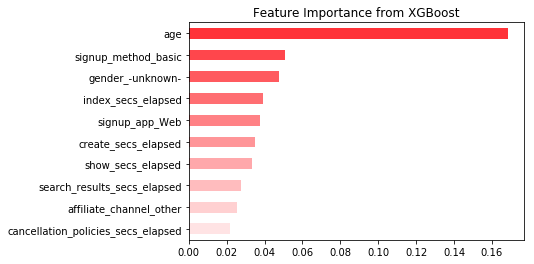

In [154]:
color_map10 = ['#ffe3e4',
 '#ffd0d1',
 '#ffbcbe',
 '#ffa8ab',
 '#ff9598',
 '#ff8185',
 '#ff6e72',
 '#ff5a5f',
 '#ff464c',
 '#ff3339']
fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['Strength']).sort_values('Strength', ascending=False)
fi.iloc[:10,:].sort_values('Strength', ascending=True)['Strength'].plot(kind='barh', color=color_map10 )
plt.title('Feature Importance from XGBoost')
fi

In [129]:
li = [] 
for val in ['#ff3339', '#ff464c', '#ff5a5f', '#ff6e72', '#ff8185' , '#ff9598', '#ffa8ab','#ffbcbe','#ffd0d1','#ffe3e4']:
    li = [val] + li
li


['#ffe3e4',
 '#ffd0d1',
 '#ffbcbe',
 '#ffa8ab',
 '#ff9598',
 '#ff8185',
 '#ff6e72',
 '#ff5a5f',
 '#ff464c',
 '#ff3339']

In [108]:
df_findings = df1.copy(deep=True)

df_findings.groupby('country_destination').sum()['gender_-unknown-']

country_destination
AU         143.0
CA         491.0
DE         284.0
ES         715.0
FR        1713.0
GB         758.0
IT        1040.0
NDF      66670.0
NL         227.0
PT          69.0
US       20109.0
other     3469.0
Name: gender_-unknown-, dtype: float64

In [106]:
mapper = df_findings.groupby('country_destination').count()['gender_-unknown-'].sort_values(ascending=False).copy(deep=True)

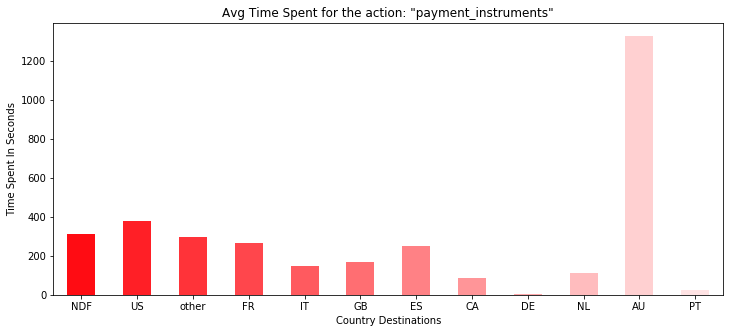

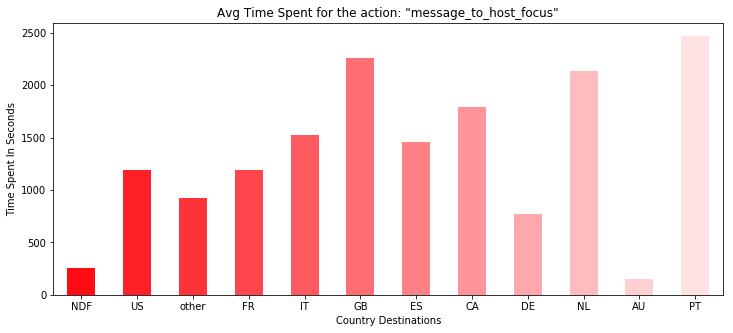

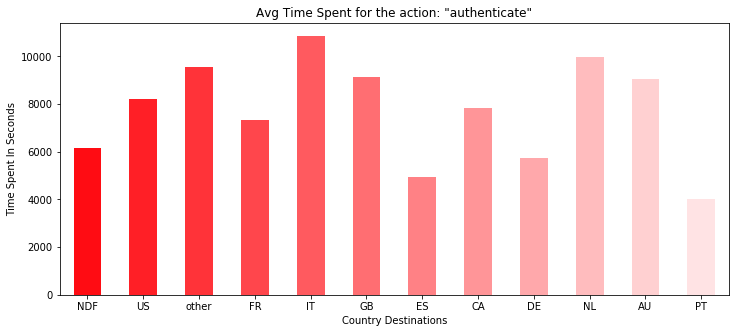

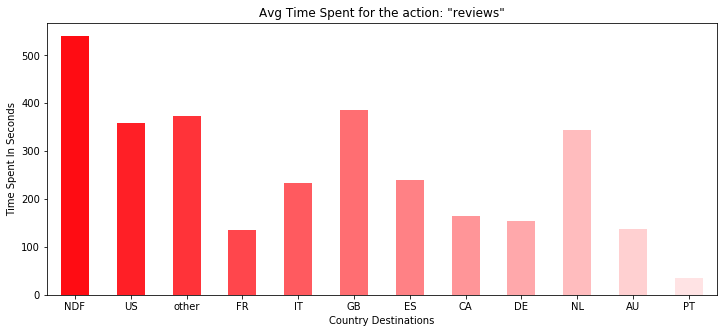

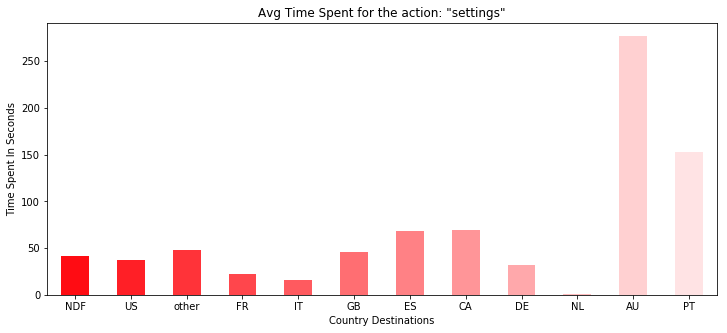

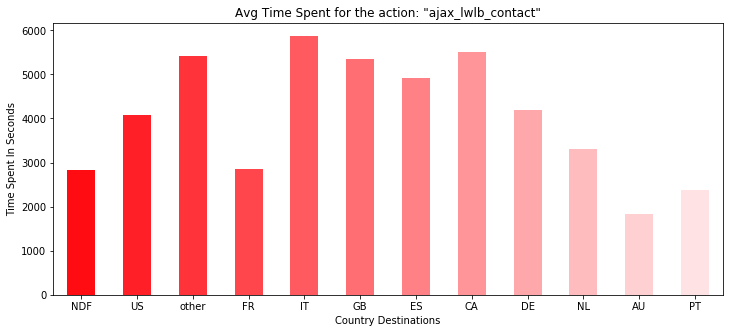

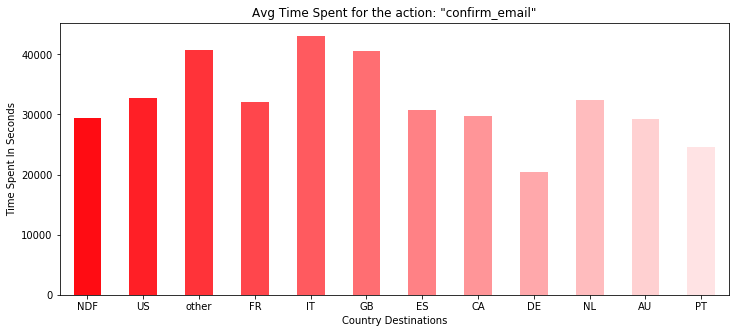

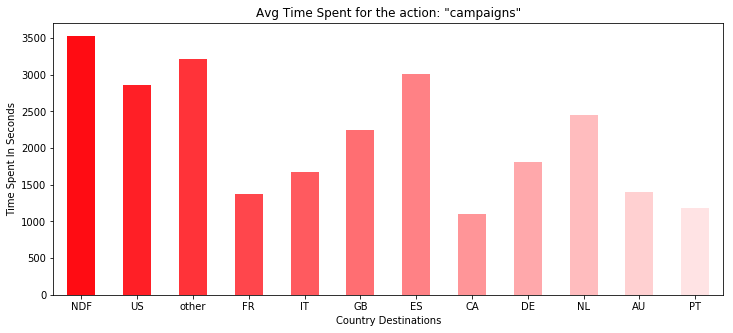

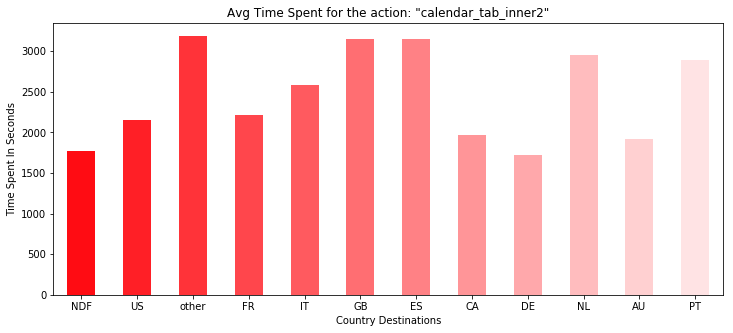

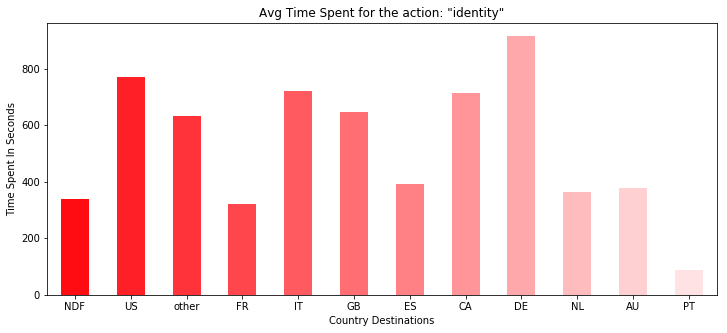

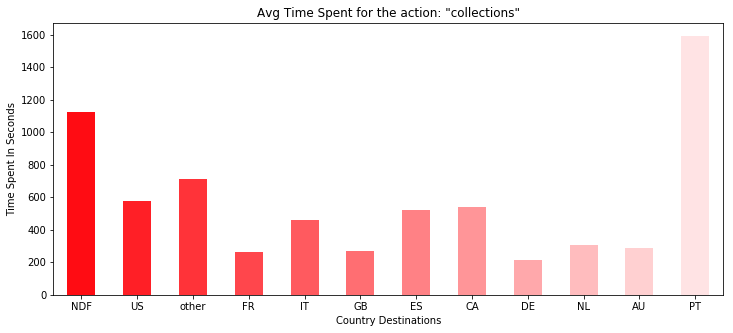

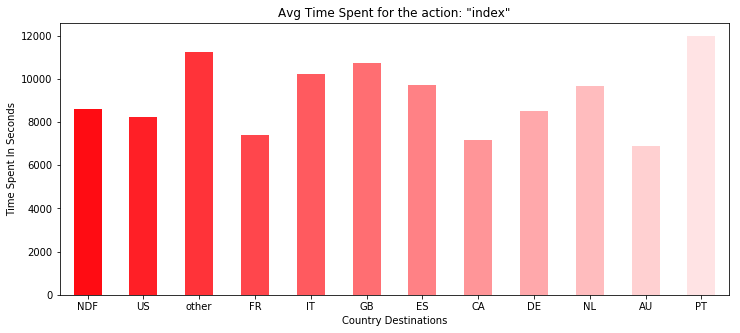

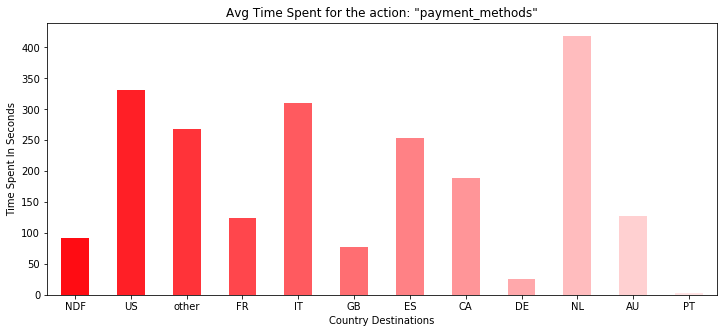

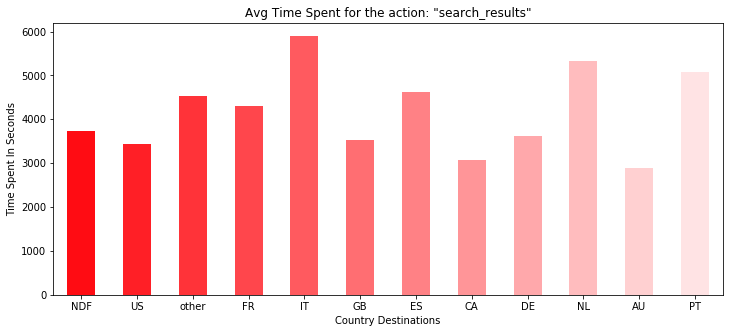

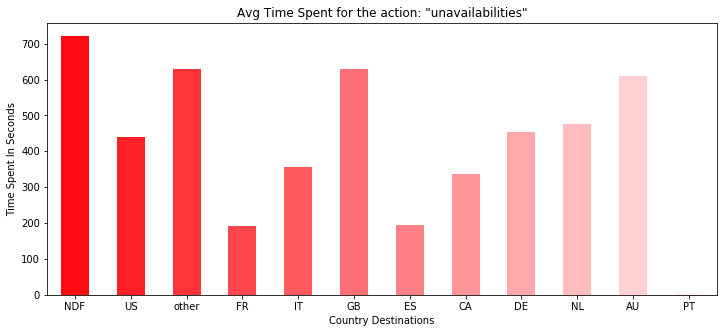

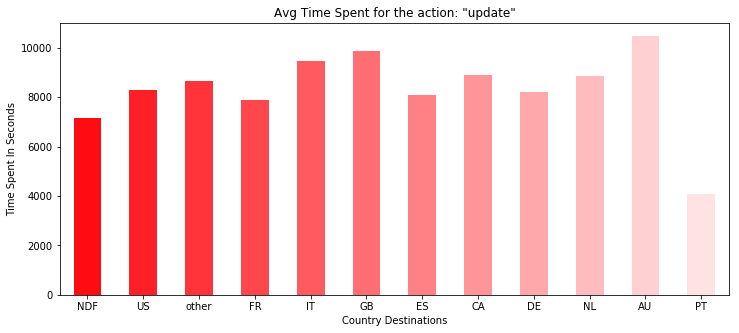

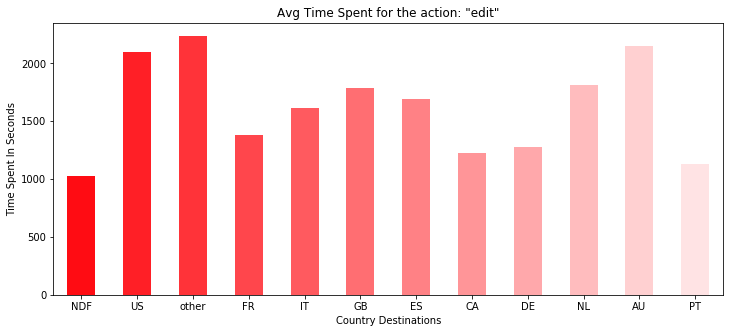

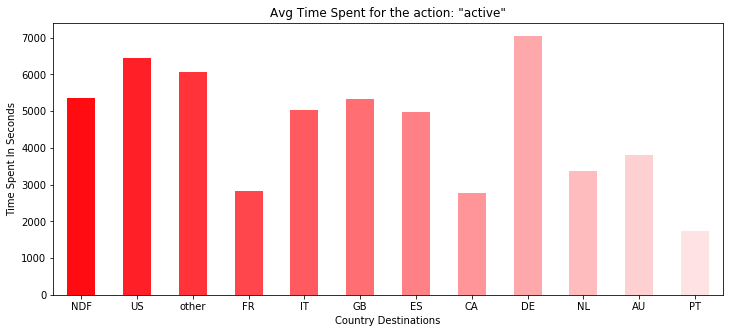

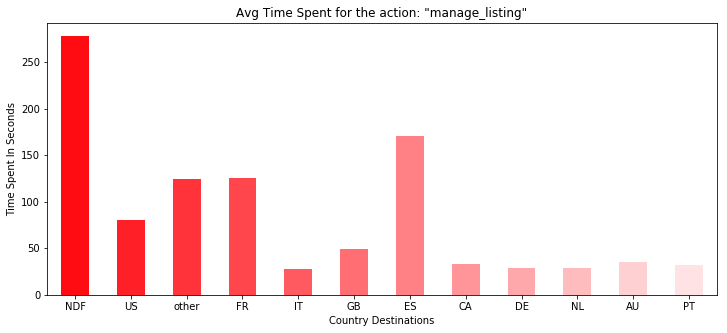

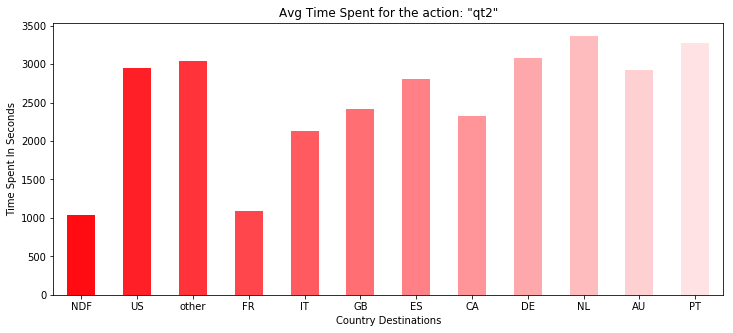

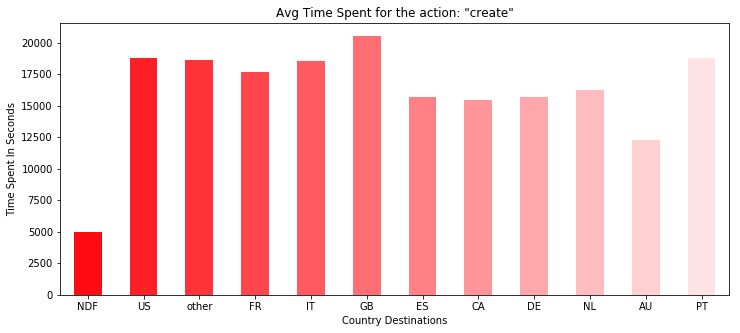

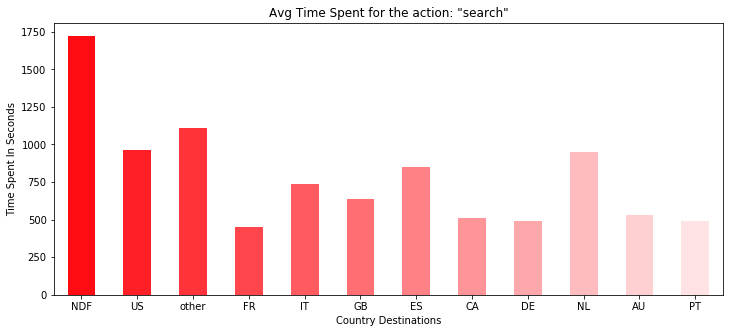

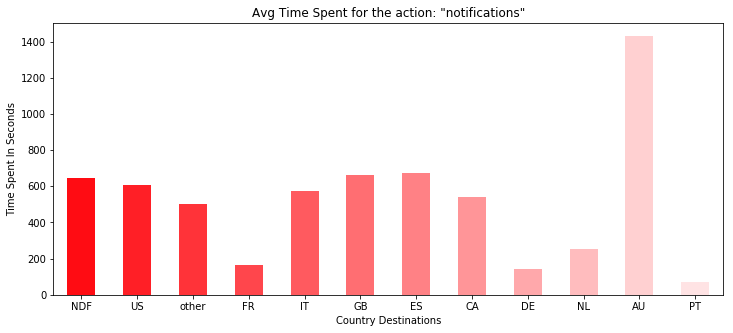

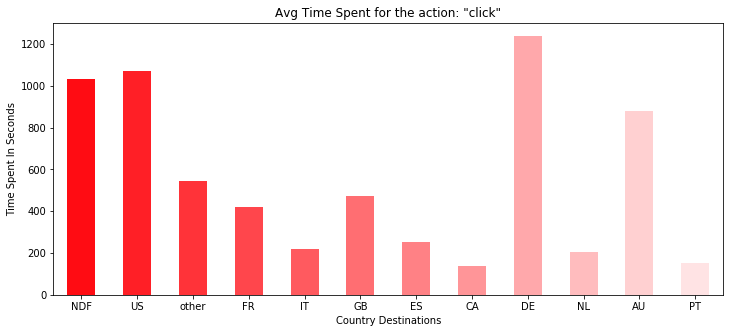

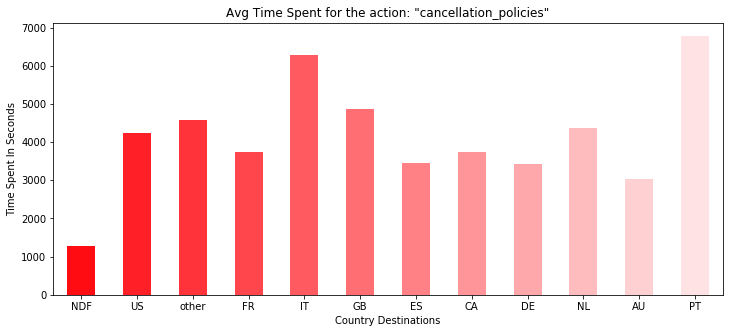

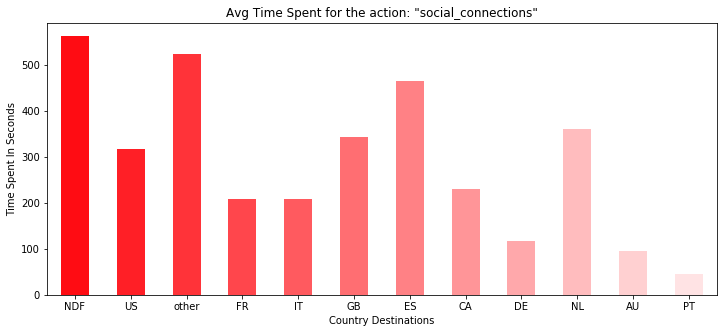

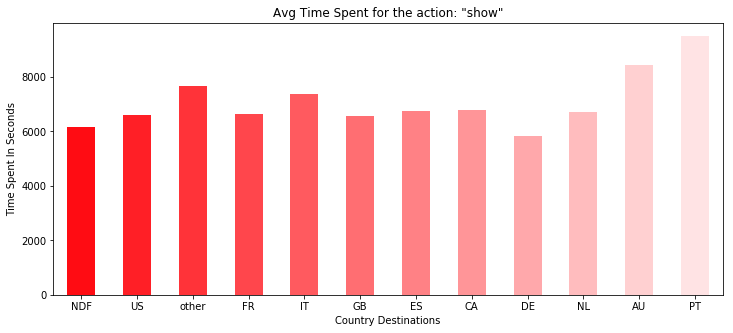

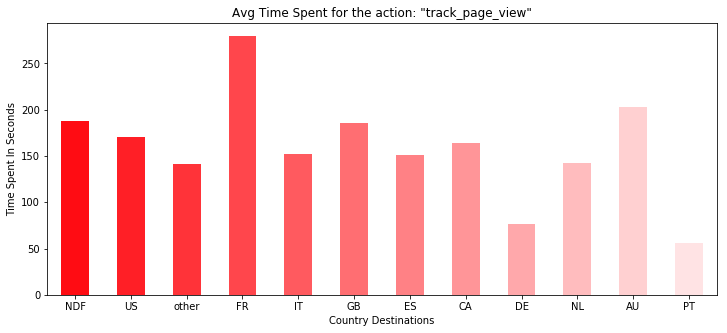

,age,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_flow_0,signup_flow_1,...,social_connections_secs_elapsed,show_secs_elapsed,track_page_view_secs_elapsed,signup_method_weibo,signup_flow_14,language_-unknown-,first_browser_IBrowse,first_browser_Nintendo Browser,first_browser_UC Browser,mapper
country_destination,,,,,,,,,,,,,,,,,,,,,
NDF,37.240776,0.535317,0.249295,0.214536,0.000851,0.705347,0.291080,0.003573,0.761544,0.007050,...,563.626555,6154.984038,187.259782,0.0,0.0,0.0,0.0,0.0,0.0,124543
US,36.783090,0.322384,0.363826,0.311931,0.001860,0.728325,0.270408,0.001267,0.778825,0.001940,...,316.680101,6585.414775,170.402206,0.0,0.0,0.0,0.0,0.0,0.0,62376
other,37.111452,0.343670,0.313057,0.341094,0.002180,0.736081,0.262730,0.001189,0.804934,0.001882,...,524.661779,7676.260254,141.409550,0.0,0.0,0.0,0.0,0.0,0.0,10094
FR,37.620346,0.341031,0.390603,0.265777,0.002588,0.749950,0.249453,0.000597,0.805694,0.000796,...,208.430221,6644.083217,279.678678,0.0,0.0,0.0,0.0,0.0,0.0,5023
IT,37.560847,0.366843,0.384832,0.246561,0.001764,0.757319,0.241975,0.000705,0.805996,0.002116,...,208.813757,7385.759436,152.071252,0.0,0.0,0.0,0.0,0.0,0.0,2835
GB,38.378657,0.326162,0.379088,0.293460,0.001291,0.743115,0.256885,0.000000,0.818417,0.001291,...,342.917814,6550.775818,185.743546,0.0,0.0,0.0,0.0,0.0,0.0,2324
ES,35.943086,0.317919,0.379280,0.301023,0.001779,0.711872,0.287239,0.000889,0.787906,0.002223,...,465.391285,6762.260560,150.620276,0.0,0.0,0.0,0.0,0.0,0.0,2249
CA,37.574930,0.343838,0.318627,0.334034,0.003501,0.773810,0.225490,0.000700,0.784314,0.003501,...,231.257003,6785.067927,163.811625,0.0,0.0,0.0,0.0,0.0,0.0,1428
DE,36.969840,0.267672,0.337418,0.392083,0.002828,0.694628,0.304430,0.000943,0.803016,0.000943,...,117.448633,5830.368520,76.597549,0.0,0.0,0.0,0.0,0.0,0.0,1061


In [110]:
secs = df_findings.groupby('country_destination').mean().copy(deep=True)
secs = secs.merge(pd.DataFrame(mapper), left_index=True,right_index=True)
secs.rename(mapper={'gender_-unknown-_y': 'mapper', 'gender_-unknown-_x':'gender_-unknown-'}, axis=1, inplace=True)
secs.sort_values('mapper', ascending=False, inplace =True)

for col in top10_cumulative:
    column = col + '_secs_elapsed'
    plt.figure(figsize=(12,5))
    secs[column].plot(kind='bar', color=['#ff0c13', '#ff1f26', '#ff3339', '#ff464c', '#ff5a5f', '#ff6e72', '#ff8185' , '#ff9598', '#ffa8ab','#ffbcbe','#ffd0d1','#ffe3e4'])
    plt.ylabel('Time Spent In Seconds')
    plt.xlabel('Country Destinations')
    plt.xticks(rotation='horizontal')
    plt.title('Avg Time Spent for the action: "{}"'.format(col))
    plt.show()

secs

In [61]:
sns.palplot(sns.color_palette("#FF5A5F"))

ValueError: #FF5A5F is not a valid palette name

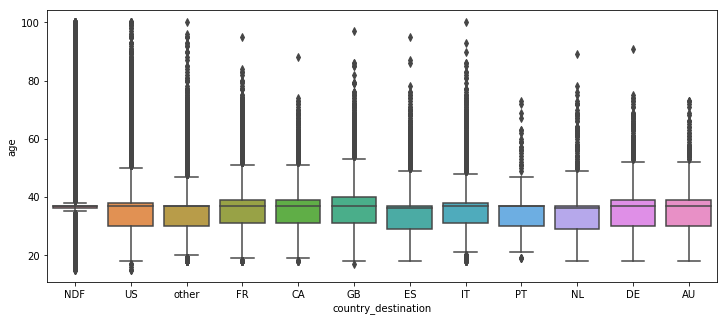

In [155]:
df1['age']
plt.figure(figsize=(12,5))
sns.boxplot(x='country_destination', y='age', data=df1)

In [135]:
df1['age'].value_counts()

 37.0     91684
 30.0      6124
 31.0      6016
 29.0      5963
 28.0      5939
 32.0      5855
 27.0      5738
 33.0      5527
 26.0      5044
 34.0      5029
 35.0      4860
 25.0      4459
 36.0      4083
 38.0      3384
 24.0      3220
 39.0      2998
 40.0      2766
 41.0      2538
 23.0      2462
 42.0      2243
 45.0      2149
 44.0      2137
 43.0      2056
 46.0      1875
 22.0      1702
 47.0      1646
 48.0      1469
 50.0      1387
 51.0      1337
 49.0      1331
          ...  
 16.0        26
 100.0       26
 96.0        25
 107.0       23
 101.0       23
 90.0        20
 84.0        20
 93.0        18
 106.0       17
 99.0        17
 98.0        15
 108.0       15
 92.0        14
 88.0        14
 115.0       13
 89.0        13
-4.0         12
 91.0        12
 94.0        12
 97.0        10
 15.0         8
 2.0          7
 1.0          5
 113.0        4
 4.0          3
 111.0        2
 132.0        1
 6.0          1
 112.0        1
 150.0        1
Name: age, Length: 112, 

In [156]:
xgb_more = find_top_choices(pd.DataFrame(xgb.predict_proba(kaggle_test), columns=xgb.classes_, index=kaggle_test.index), threshold=1)
xgb_more

,country
id,
5uwns89zht,NDF
5uwns89zht,US
5uwns89zht,other
5uwns89zht,FR
5uwns89zht,IT
jtl0dijy2j,NDF
jtl0dijy2j,US
jtl0dijy2j,other
jtl0dijy2j,FR


In [167]:
for col, val in zip(kaggle_test.loc['sr4ntmalz2',:].index, kaggle_test.loc['sr4ntmalz2',:].values):
    print(col, val)

age 37.0
gender_-unknown- 1.0
gender_FEMALE 0.0
gender_MALE 0.0
gender_OTHER 0.0
signup_method_basic 1.0
signup_method_facebook 0.0
signup_method_google 0.0
signup_flow_0 1.0
signup_flow_1 0.0
signup_flow_2 0.0
signup_flow_3 0.0
signup_flow_4 0.0
signup_flow_5 0.0
signup_flow_6 0.0
signup_flow_8 0.0
signup_flow_10 0.0
signup_flow_12 0.0
signup_flow_15 0.0
signup_flow_16 0.0
signup_flow_20 0.0
signup_flow_21 0.0
signup_flow_23 0.0
signup_flow_24 0.0
signup_flow_25 0.0
language_ca 0.0
language_cs 0.0
language_da 0.0
language_de 0.0
language_el 0.0
language_en 1.0
language_es 0.0
language_fi 0.0
language_fr 0.0
language_hr 0.0
language_hu 0.0
language_id 0.0
language_is 0.0
language_it 0.0
language_ja 0.0
language_ko 0.0
language_nl 0.0
language_no 0.0
language_pl 0.0
language_pt 0.0
language_ru 0.0
language_sv 0.0
language_th 0.0
language_tr 0.0
language_zh 0.0
affiliate_channel_api 0.0
affiliate_channel_content 0.0
affiliate_channel_direct 1.0
affiliate_channel_other 0.0
affiliate_chann

In [163]:
pd.DataFrame(xgb.predict_proba(kaggle_test), columns=xgb.classes_, index=kaggle_test.index)

,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
id,,,,,,,,,,,,
5uwns89zht,0.002581,0.002694,0.002863,0.007435,0.011814,0.005947,0.008929,0.652711,0.002701,0.001320,0.259873,0.041133
jtl0dijy2j,0.001008,0.001813,0.001565,0.003493,0.005933,0.004475,0.005866,0.840019,0.001559,0.000794,0.110058,0.023417
xx0ulgorjt,0.001163,0.004979,0.002221,0.007117,0.015133,0.007376,0.011535,0.786902,0.002191,0.001145,0.127500,0.032737
6c6puo6ix0,0.001523,0.004788,0.002902,0.007011,0.015167,0.007267,0.009372,0.787786,0.002158,0.000914,0.131408,0.029704
czqhjk3yfe,0.003195,0.012661,0.006154,0.014256,0.043565,0.019685,0.029098,0.496347,0.005742,0.001795,0.313659,0.053845
szx28ujmhf,0.004174,0.008955,0.006149,0.015276,0.032489,0.013841,0.019929,0.338312,0.004350,0.001517,0.491173,0.063835
guenkfjcbq,0.004141,0.008456,0.004920,0.007968,0.021150,0.018567,0.012109,0.527846,0.005033,0.001715,0.328497,0.059599
tkpq0mlugk,0.001713,0.005806,0.003237,0.007885,0.019797,0.008819,0.011376,0.725589,0.002799,0.001063,0.177200,0.034714
3xtgd5p9dn,0.001037,0.008653,0.004420,0.010932,0.015607,0.008713,0.019215,0.720946,0.005162,0.001187,0.163711,0.040417


In [ ]:
cm = confusion_matrix(y_test, classifier.predict_classes(X_test), labels= [1,0])
print (classification_report(y_test, classifier.predict_classes(X_test)))
cm = pd.DataFrame(cm, index=['True_High','True_Low'], columns = ['Pred_High','Pred_Low'])

### Find and Print AUC
fpr, tpr, _ = roc_curve(y_test, pd.DataFrame(classifier.predict_proba(X_test)).iloc[:,0])
roc_auc = auc(fpr, tpr)
print('AUC: {}'.format(roc_auc))

cm
